# Milestone 3: Anomaly Detection and Visualization
## Objective
The objective of this milestone is to detect, label, and visualize anomalous
health patterns from fitness device data. This milestone reuses the forecasting
and clustering outputs developed in Milestone 2, without rebuilding models,
and focuses on identifying abnormal behavior using residual analysis,
domain-based thresholds, and clustering-based outliers.


In [17]:
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger("tsfresh").setLevel(logging.ERROR)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [18]:
df = pd.read_csv('/content/cleaned_fitbit.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()


,user_id,timestamp,heart_rate,steps,sleep
0,2026352035,2016-04-17,68.656250,838,7.283333
1,2026352035,2016-04-25,99.505814,6017,8.433333
2,2026352035,2016-05-02,84.134571,7018,8.516667
3,2026352035,2016-05-09,98.233901,10685,8.850000
4,2347167796,2016-04-13,73.812905,10352,7.783333


Reusing Milestone 2: Clustering

In [21]:
import warnings
import logging
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
warnings.filterwarnings("ignore")
logging.getLogger("tsfresh").setLevel(logging.ERROR)

features = extract_features(
    df,
    column_id="user_id",
    column_sort="timestamp",
    default_fc_parameters=EfficientFCParameters(),
    disable_progressbar=True
)

impute(features)


,heart_rate__variance_larger_than_standard_deviation,heart_rate__has_duplicate_max,heart_rate__has_duplicate_min,heart_rate__has_duplicate,heart_rate__sum_values,heart_rate__abs_energy,heart_rate__mean_abs_change,heart_rate__mean_change,heart_rate__mean_second_derivative_central,heart_rate__median,...,sleep__fourier_entropy__bins_5,sleep__fourier_entropy__bins_10,sleep__fourier_entropy__bins_100,sleep__permutation_entropy__dimension_3__tau_1,sleep__permutation_entropy__dimension_4__tau_1,sleep__permutation_entropy__dimension_5__tau_1,sleep__permutation_entropy__dimension_6__tau_1,sleep__permutation_entropy__dimension_7__tau_1,sleep__query_similarity_count__query_None__threshold_0.0,sleep__mean_n_absolute_max__number_of_maxima_7
2026352035,1.0,0.0,0.0,0.0,350.530536,31343.612942,20.106712,9.859217,-4.187558,91.184236,...,1.098612,1.098612,1.098612,-0.000000,-0.000000,2.639057,2.754694,2.687639,0.0,8.832143
2347167796,1.0,0.0,0.0,0.0,1113.457715,82956.405998,4.792105,-0.781657,-0.357900,73.812905,...,1.039721,1.213008,2.079442,1.671595,2.094729,2.271869,2.302585,2.197225,0.0,7.971429
4020332650,1.0,0.0,0.0,0.0,657.613850,54592.228993,9.411407,-1.554187,-1.902139,80.748614,...,1.054920,1.332179,1.332179,1.560710,1.609438,1.386294,1.098612,0.693147,0.0,6.471429
4388161847,1.0,0.0,0.0,1.0,1577.610332,104435.875056,5.362032,-0.326042,-0.210339,64.139705,...,1.303876,1.626021,2.458311,1.567236,2.227438,2.649159,2.944439,2.890372,0.0,8.800000
4558609924,1.0,0.0,0.0,0.0,433.266258,38185.924164,15.049021,4.802271,4.726092,85.662387,...,1.098612,1.098612,1.098612,1.098612,0.693147,-0.000000,2.754694,2.687639,0.0,8.832143
5553957443,1.0,0.0,0.0,0.0,2101.010896,143088.393928,5.556995,-0.005660,0.028905,66.543450,...,1.353591,1.890363,2.566599,1.666426,2.561835,3.090460,3.258097,3.218876,0.0,10.614286
5577150313,1.0,0.0,0.0,0.0,1792.374448,123986.636426,4.919005,0.055384,-0.047910,69.507809,...,1.574097,2.106577,2.540036,1.718710,2.630555,2.965016,3.044522,2.995732,0.0,8.950000
6117666160,1.0,0.0,0.0,0.0,1477.035897,121363.063139,3.450420,-0.621259,-0.093758,82.538421,...,0.950271,1.470808,2.302585,1.630433,2.176186,2.639057,2.564949,2.484907,0.0,9.209524
6775888955,1.0,0.0,0.0,0.0,242.582321,19621.457545,2.389046,-1.062622,2.389046,80.594501,...,0.693147,0.693147,0.693147,-0.000000,2.135457,2.639057,2.754694,2.687639,0.0,8.832143
6962181067,1.0,0.0,0.0,0.0,2404.053129,186945.963238,4.812269,-0.310686,0.016921,77.017628,...,1.276720,1.721402,2.426015,1.711908,2.818412,3.295837,3.258097,3.218876,0.0,8.864286


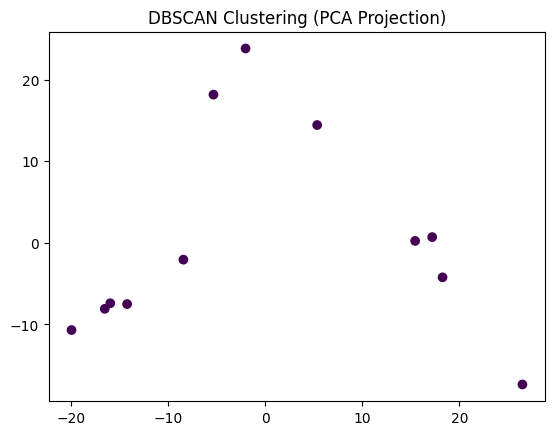

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features.fillna(0))

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

dbscan = DBSCAN(eps=1.5, min_samples=8)
cluster_labels = dbscan.fit_predict(X_pca)

features['cluster'] = cluster_labels

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title("DBSCAN Clustering (PCA Projection)")
plt.show()


Reusing Milestone 2: Prophet Forecasting

In [23]:
selected_users = df['user_id'].unique()[:4]
metrics = ['heart_rate', 'steps', 'sleep']

results = []

for user in selected_users:
    user_data = df[df['user_id'] == user]

    for metric in metrics:
        df_prophet = user_data[['timestamp', metric]].rename(
            columns={'timestamp': 'ds', metric: 'y'}
        )

        df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')
        df_prophet = df_prophet.dropna()

        if len(df_prophet) < 5:
            continue

        model = Prophet(daily_seasonality=True)
        model.fit(df_prophet)

        forecast = model.predict(df_prophet)
        df_prophet['yhat'] = forecast['yhat']
        df_prophet['residual'] = df_prophet['y'] - df_prophet['yhat']
        df_prophet['user_id'] = user
        df_prophet['metric'] = metric

        results.append(df_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_

Combine Prophet Outputs

In [26]:
selected_users = df['user_id'].unique()[:4]
metrics = ['heart_rate', 'sleep']
prophet_results = []

selected_users = df['user_id'].unique()[:4]
metrics = ['heart_rate', 'sleep']

for user in selected_users:
    user_data = df[df['user_id'] == user]

    for metric in metrics:
        temp = user_data[['timestamp', metric]].rename(
            columns={'timestamp': 'ds', metric: 'y'}
        )

        temp['y'] = pd.to_numeric(temp['y'], errors='coerce')
        temp = temp.dropna()

        if len(temp) < 5:
            continue

        model = Prophet(daily_seasonality=True)
        model.fit(temp)

        forecast = model.predict(temp)
        temp['yhat'] = forecast['yhat']
        temp['residual'] = temp['y'] - temp['yhat']
        temp['metric'] = metric
        temp['user_id'] = user

        prophet_results.append(temp)

prophet_df = pd.concat(prophet_results, ignore_index=True)



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 5.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_

In [27]:
threshold = prophet_df['residual'].quantile(0.90)
prophet_df['residual_anomaly'] = (
    abs(prophet_df['residual']) > threshold )



In [28]:
prophet_df['domain_anomaly'] = False

# Heart rate rule
prophet_df.loc[
    (prophet_df['metric'] == 'heart_rate') &
    ((prophet_df['y'] < 50) | (prophet_df['y'] > 100)),
    'domain_anomaly'
] = True

# Sleep rule
prophet_df.loc[
    (prophet_df['metric'] == 'sleep') &
    ((prophet_df['y'] < 5) | (prophet_df['y'] > 9)),
    'domain_anomaly'
] = True


Final Anomaly Label

In [29]:
prophet_df['final_anomaly'] = (
    prophet_df['residual_anomaly'] |
    prophet_df['domain_anomaly']
)

prophet_df['final_anomaly'].value_counts()


,count
final_anomaly,
False,80
True,14


Heart Rate Visualization

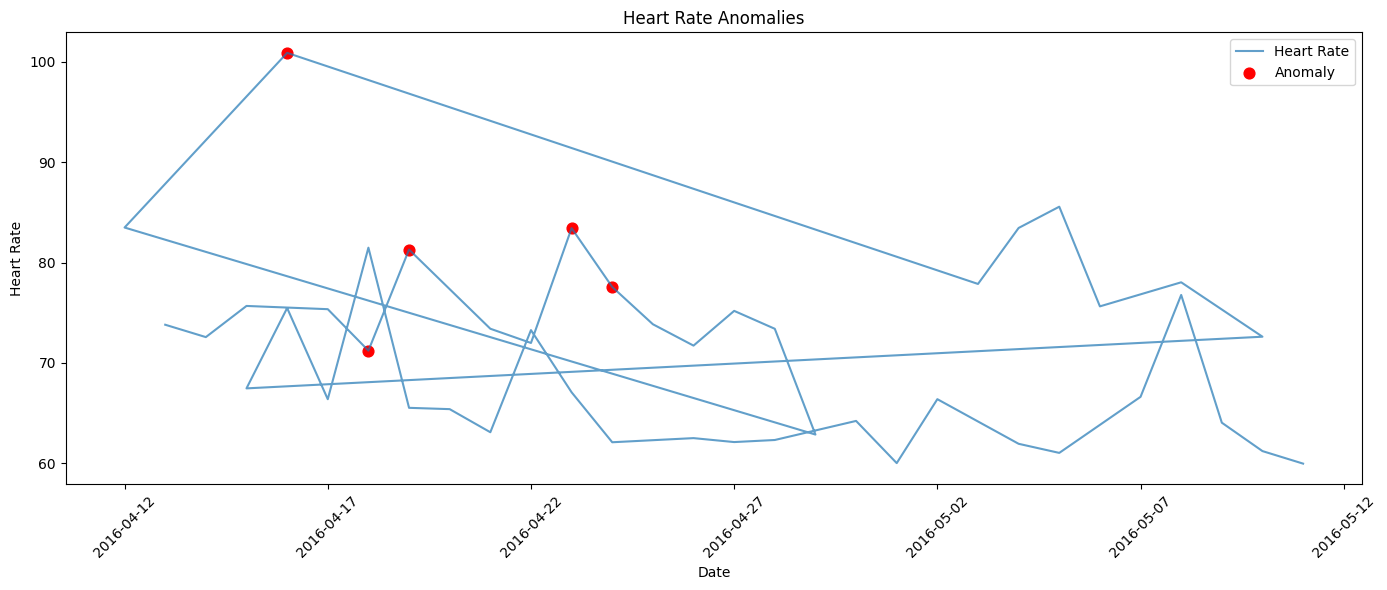

In [46]:
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))

plt.plot(hr_data['ds'], hr_data['y'], label='Heart Rate', alpha=0.7)
plt.scatter(
    hr_data[hr_data['final_anomaly']]['ds'],
    hr_data[hr_data['final_anomaly']]['y'],
    color='red',
    label='Anomaly',
    s=60
)

plt.title("Heart Rate Anomalies")
plt.xlabel("Date")
plt.ylabel("Heart Rate")
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Sleep Pattern Visualization

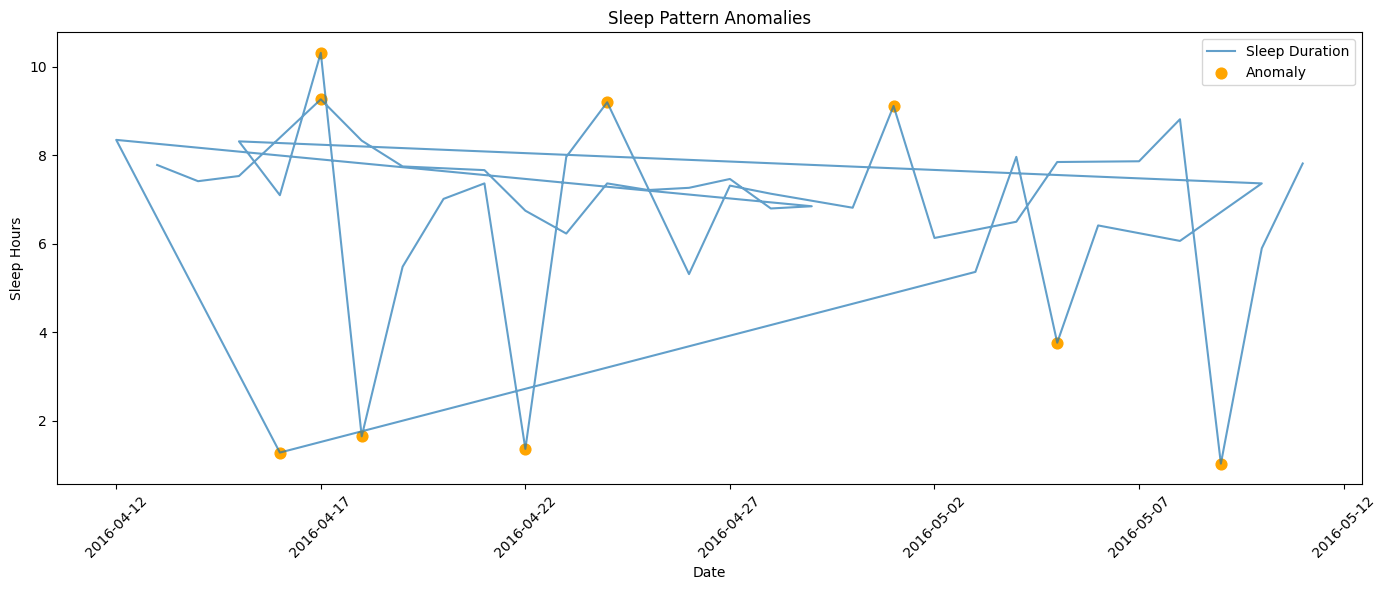

In [45]:
import matplotlib.dates as mdates

sleep_data = prophet_df[prophet_df['metric'] == 'sleep']

plt.figure(figsize=(14,6))

plt.plot(
    sleep_data['ds'],
    sleep_data['y'],
    label='Sleep Duration',
    alpha=0.7
)

plt.scatter(
    sleep_data[sleep_data['final_anomaly']]['ds'],
    sleep_data[sleep_data['final_anomaly']]['y'],
    color='orange',
    label='Anomaly',
    s=60
)

plt.title("Sleep Pattern Anomalies")
plt.xlabel("Date")
plt.ylabel("Sleep Hours")
plt.legend()

# Show fewer, readable date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
